In [ ]:
!pip install tensorflow #Leave this cell raw if you don't need to install packages, otherwise switch cell type to code and run it
!pip install keras-tuner


In [5]:
import numpy as np
import scipy
import matplotlib
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
#it might need you to install tensorflow manually. I was able to do that by typing "python3 -m pip install 'tensorflow'" into the terminal.
import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import sklearn
import keras_tuner as kerastuner
from google.colab import files
from tensorflow.keras.preprocessing import image
#for sklearn, use "pip install -U scikit-learn"

In [6]:
import kagglehub
download_path = kagglehub.dataset_download("mostafaabla/garbage-classification")
possible_subfolder = os.path.join(download_path, "garbage_classification")
BASE_PATH = possible_subfolder if os.path.exists(possible_subfolder) else download_path

print(f"Using BASE_PATH: {BASE_PATH}")

Using Colab cache for faster access to the 'garbage-classification' dataset.
Using BASE_PATH: /kaggle/input/garbage-classification/garbage_classification


    category                                              image  \
0  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                path  
0  /kaggle/input/garbage-classification/garbage_c...  
1  /kaggle/input/garbage-classification/garbage_c...  
2  /kaggle/input/garbage-classification/garbage_c...  
3  /kaggle/input/garbage-classification/garbage_c...  
4  /kaggle/input/garbage-classification/garbage_c...  
/kaggle/input/garbage-classification/garbage_classification/metal/metal510.jpg


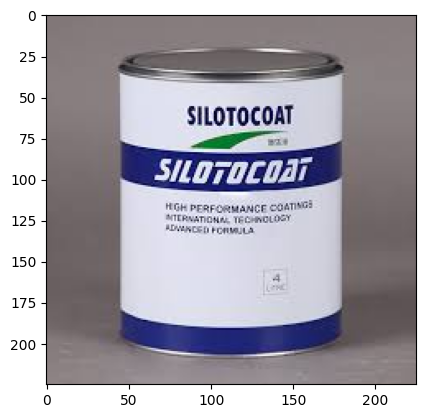

In [8]:
#dataframe with each image's category, image file, and filename. May or may not actually get used
image_frame = pd.DataFrame(columns=('category', 'image', 'path'))

#a big array of filenames
filename_array = []
#a big array of images (our "X")
image_array = []
#a big array of categories (our "y")
category_array = []

i = 0

#we basically just run the for loop below six times, once for each category, filling out the arrays and dataframe.
categories = [
    'cardboard', 'metal', 'paper', 'plastic', 'trash', 'clothes', 'green-glass', 'brown-glass', 'white-glass'
]

for category in categories:
    # Construct the full path to the category directory
    category_path = os.path.join(BASE_PATH, category)
    for filename in os.listdir(category_path):
        current_path = os.path.join(category_path, filename)
        current_image = Image.open(current_path)
        image_frame.loc[i] = {"category" : category, "image" : current_image, "path" : current_path}
        category_array.append(category)
        image_array.append(current_image)
        filename_array.append(current_path)
        i += 1

#test display
print(image_frame.head(5))
print(filename_array[1392])
plt.imshow(image_array[1392])
plt.show()

In [9]:
image_frame['category'] = image_frame['category'].replace(
    ['green-glass', 'brown-glass', 'white-glass'], 'glass'
)

print(image_frame['category'].value_counts())

category
clothes      5325
glass        2011
paper        1050
cardboard     891
plastic       865
metal         769
trash         697
Name: count, dtype: int64


In [10]:
#Next we'll use the dataframe indexes to make a train-test split.
indices = np.arange(0, len(image_frame))
train_indices, test_indices = sklearn.model_selection.train_test_split(indices, test_size=0.2)

train_frame = image_frame.loc[train_indices]
print(train_frame.head(5))

test_frame = image_frame.loc[test_indices]
print(test_frame.head(5))

       category                                              image  \
4005      trash  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
546   cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3387    plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4041      trash  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1528      metal  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                   path  
4005  /kaggle/input/garbage-classification/garbage_c...  
546   /kaggle/input/garbage-classification/garbage_c...  
3387  /kaggle/input/garbage-classification/garbage_c...  
4041  /kaggle/input/garbage-classification/garbage_c...  
1528  /kaggle/input/garbage-classification/garbage_c...  
     category                                              image  \
4171    trash  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2374    paper  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4190    trash  <PIL.JpegIma

In [11]:

train_datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

#This train datagen thingy should normalize our images. I feed it in the paths from the dataframe.
train_set1 = train_datagen1.flow_from_dataframe(train_frame, x_col="path", y_col="category", target_size=(64,64),
                                                    class_mode="categorical",batch_size=32)

test_set1 = train_datagen1.flow_from_dataframe(test_frame, x_col="path", y_col="category", target_size=(64,64),
                                                    class_mode="categorical",batch_size=32)

Found 9286 validated image filenames belonging to 7 classes.
Found 2322 validated image filenames belonging to 7 classes.


In [15]:
def build_model(hp):
    model = tf.keras.models.Sequential() #Creates a model with no layers
    model.add(tf.keras.layers.Input(shape=(64, 64, 3)))

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), #We add onto the layers, but we specify a range of values
        kernel_size=3,                                                         #with a step size, so our hyperparameter tuning knows what to test for.
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    ))

    model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #

Num GPUs Available:  1


In [16]:
tuner = kerastuner.Hyperband( #https://keras.io/keras_tuner/api/tuners/hyperband/
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='modelstesting',
    project_name='trash_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_set1,
             validation_data=test_set1,
             epochs=15,
             callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |conv_1_filter
128               |128               |conv_2_filter
448               |448               |dense_units
0.4               |0.4               |dropout_rate
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 14/291 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.3502 - loss: 2.3163

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The best number of units in the dense layer is: {best_hps.get('dense_units')}")
print(f"The best dropout rate: {best_hps.get('dropout_rate')}")
print(f"The best learning rate for the optimizer is: {best_hps.get('learning_rate')}")

The best number of units in the dense layer is: 512
The best dropout rate: 0.30000000000000004
The best learning rate for the optimizer is: 0.001


In [ ]:
#Build the model with the best hyperparameters and train it over 20 epochs now
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set1, validation_data=test_set1, epochs=20)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.5590 - loss: 1.3235 - val_accuracy: 0.7097 - val_loss: 0.8299
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.7074 - loss: 0.8295 - val_accuracy: 0.7498 - val_loss: 0.7005
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.7457 - loss: 0.7082 - val_accuracy: 0.7498 - val_loss: 0.7364
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.7722 - loss: 0.6379 - val_accuracy: 0.7786 - val_loss: 0.6367
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.8000 - loss: 0.5776 - val_accuracy: 0.8114 - val_loss: 0.5647
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.8215 - loss: 0.5159 - val_accuracy: 0.8101 - val_loss: 0.5671
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.8232 - loss: 0.5001 - val_accuracy: 0.8333 - val_loss: 0.5395
Epoch 8/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.8442 - loss: 0

In [12]:
cnn1 = tf.keras.models.Sequential([ # Old initial cell block without hyperparameter tuning
    tf.keras.layers.Input(shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=7, activation='softmax')
])
#if we're trying to push the model to care more about false positives than false negatives,
#maybe this is where we do that? we'll have to look into it further.
cnn1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = cnn1.fit(
    train_set1,
    validation_data=test_set1,
    epochs=10,
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5056 - loss: 1.3966

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


291/291 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.5059 - loss: 1.3959 - val_accuracy: 0.6624 - val_loss: 0.9223
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.6615 - loss: 0.9668 - val_accuracy: 0.6968 - val_loss: 0.7914
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.6982 - loss: 0.8681 - val_accuracy: 0.7407 - val_loss: 0.7227
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.7178 - loss: 0.7819 - val_accuracy: 0.7489 - val_loss: 0.7008
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.7359 - loss: 0.7530 - val_accuracy: 0.7782 - val_loss: 0.6399
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.7480 - loss: 0.7037 - val_accuracy: 0.7873 - val_loss: 0.6107
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - accuracy: 0.7647 - loss: 0.6764 - val_accuracy: 0.8010 - val_loss: 0.6011
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.7666 - loss: 0.6469 - val

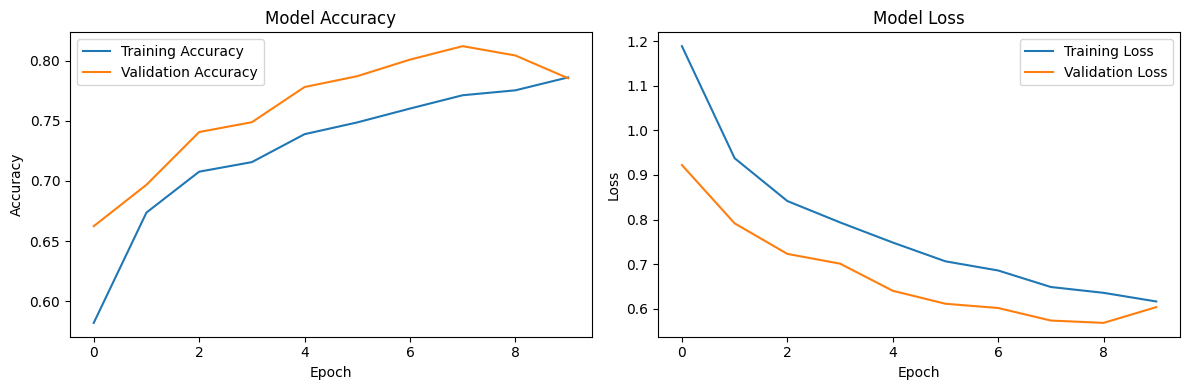

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7889 - loss: 0.5807

Test Accuracy: 0.7855
Test Loss: 0.6005


In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = cnn1.evaluate(test_set1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
cnn1 = tf.keras.models.Sequential([ # Old initial cell block without hyperparameter tuning
    tf.keras.layers.Input(shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=7, activation='softmax')
])
#if we're trying to push the model to care more about false positives than false negatives,
#maybe this is where we do that? we'll have to look into it further.
cnn1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnn1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#the tutorial i'm using might be using different definitions for train/validation/test splits
#than we do? if so, probably wouldn't be too hard to fix it at least.
history_initial = cnn1.fit(
    train_set1,
    validation_data=test_set1,
    epochs=10,
)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.5395 - loss: 1.3508 - val_accuracy: 0.7283 - val_loss: 0.8456
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.6790 - loss: 0.9073 - val_accuracy: 0.7433 - val_loss: 0.7467
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.7081 - loss: 0.8097 - val_accuracy: 0.7265 - val_loss: 0.7562
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.7289 - loss: 0.7567 - val_accuracy: 0.7661 - val_loss: 0.6627
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7430 - loss: 0.7419 - val_accuracy: 0.7752 - val_loss: 0.6502
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.7477 - loss: 0.7359 - val_accuracy: 0.7894 - val_loss: 0.6421
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.7755 - loss: 0.6373 - val_accuracy: 0.7812 - val_loss: 0.6212
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.7755 - loss: 0

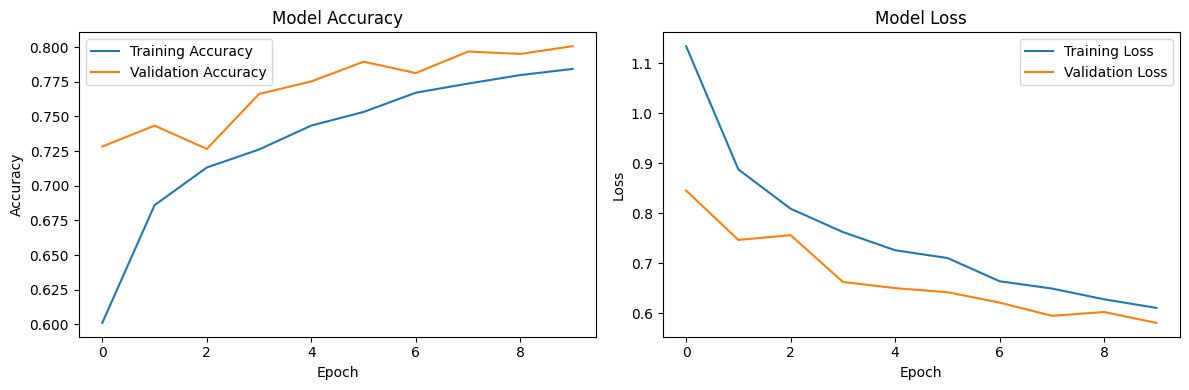

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7990 - loss: 0.5704

Test Accuracy: 0.8015
Test Loss: 0.5739


In [ ]:
h = history_initial
#compare between initial parameters (histroy_initial) and hyperparameter tuned model (history)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

#plt.savefig("img/initial_parameters.png")

plt.show()

test_loss, test_accuracy = cnn1.evaluate(test_set1) # cnn1 or model
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Saving silver.webp to silver.webp


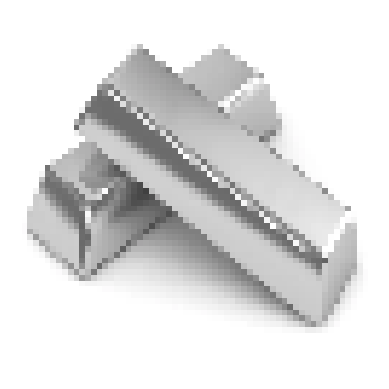

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Class: metal
Confidence: 0.93


In [ ]:
uploaded = files.upload()

class_labels = {v: k for k, v in train_set1.class_indices.items()}

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(64, 64))

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    predict = cnn1.predict(x)
    predicted_class_index = np.argmax(predict, axis=1)[0]
    predicted_label = class_labels[predicted_class_index]
    confidence = predict[0][predicted_class_index]

    print(f'Predicted Class: {predicted_label}')
    print(f'Confidence: {confidence:.2f}')

    os.remove(path)